<a href="https://colab.research.google.com/github/camilasini/IC-UFPA/blob/main/HHT%20final%20code%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Função HHT 3D e holospectrum

In [1]:
!pip install emd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 1.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import emd
from scipy.io import loadmat
import numpy as np
from scipy import ndimage

sample_rate = 200

config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 50/sample_rate
config['mask_amp_mode'] = 'ratio_sig'
config['imf_opts/sd_thresh'] = 0.05
    
from functools import partial
my_mask_sift = partial(emd.sift.mask_sift, **config)

In [3]:
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2

In [4]:
#função p calcular o hilbert huang 
def hilbert_huang(data, sample_rate=200):
     imf = my_mask_sift(data)

###2. calculando o conteudo das imfs (fase, freq e amplitude instantaneas)
     IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    
# Define sift parameters for the second level
     masks = np.array([25/2**ii for ii in range(12)])/sample_rate
     config = emd.sift.get_config('mask_sift')
     config['mask_amp_mode'] = 'ratio_sig'
     config['mask_amp'] = 2
     config['max_imfs'] = 5
     config['imf_opts/sd_thresh'] = 0.05
     config['envelope_opts/interp_method'] = 'mono_pchip'

# Sift the first 5 first level IMFs
     imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

##2.2. calculando o conteudo da imf2
     IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
    
    ###3. definindo os bins de frequencia que serão usados no histograma
     carrier_hist = (1, 50, 49, 'log') # Carrier frequency histogram 
     am_hist = (1e-2, 32, 64, 'log') # AM frequency histogram

###4. 1d, 2d e 3d hilbert huang transform
#(power over carrier frequency)
     fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

#power over time x carrier frequency)
     fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
     shht = ndimage.gaussian_filter(hht, 2)

#time averaged Holospectrum (power over carrier frequency x AM frequency)
     fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
     sholo = ndimage.gaussian_filter(holo, 1)
    #Filtro gaussiano é um filtro capaz de reduzir o nível de ruído de um sinal de entrada, a fim de diminuir a distorção numa imagem
    
     hht_by_phase, _, _ = emd.cycles.bin_by_phase(IP[:, 4], hht.T)
    
     return fcarrier, fam, spec, sholo, hht_by_phase

#Carregando dados 
média antes do holospectrum

In [ ]:
import os
import numpy as np
from scipy.io import loadmat

directory = r"/content/drive/MyDrive/Colab Notebooks/cleaned_50hz"
files = os.listdir(directory)

data=[]
channels_names = []

for filename in files:
    channels = []
    f = os.path.join(directory, filename) 
    if os.path.isfile(f):
        matdat1 = loadmat(f)
        data.append(matdat1['data'])

        for n in range(matdat1['nbchan'][0][0]):
            channels.append(matdat1['chanlocs'][0][n][0][0])
            
        channels_names.append(channels)

KeyboardInterrupt: ignored

In [ ]:
for i in range(len(data)):
  value=np.shape(data[i])
  print(value)

In [ ]:
# common element extraction form N lists
# using map() + intersection()
res = list(set.intersection(*map(set, channels_names)))
 
# printing result
print ("The common elements from N lists : " + str(res))

#Carregando dados
holospectrum antes da média

In [ ]:
import os
import numpy as np
from scipy.io import loadmat

directory = r'/content/drive/MyDrive/Colab Notebooks/teste HHT dataset'
files = os.listdir(directory)

data=[]

for filename in files:
    f = os.path.join(directory, filename) 
    fcarrier1 = []
    fam1 = []
    spec1=[]
    sholo1 = []

    if os.path.isfile(f):
        matdat1 = loadmat(f)
        data.append(matdat1['data'].flatten())

        for i in range(len(data)):
              fcarrier, fam, spec, sholo = hilbert_huang (data[i], sample_rate)

              fcarrier1.append(fcarrier)
              fam1.append(fam)
              spec1.append(spec)
              sholo1.append(sholo)


In [5]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

path = r'/content/drive/MyDrive/Colab Notebooks/cleaned_50hz/0000101_50hz.set'

matdat1 = loadmat(path)

In [48]:
(np.shape(matdat1['chanlocs']))

(1, 16)

In [49]:
for i in range(0,16):
    print(f'{i}.'+matdat1['chanlocs'][0][i][0][0])

0.F7
1.T5
2.Fp1
3.F3
4.C3
5.P3
6.T4
7.T6
8.Fp2
9.F4
10.C4
11.P4
12.O2
13.Fz
14.Pz
15.Oz


In [58]:
data = matdat1['data'][8]
fcarrier, fam, spec, sholo, hht_by_phase = hilbert_huang(data, sample_rate)

In [61]:
def holospectrum(fam, fcarrier, sholo):
   fig,ax=plt.subplots(1,1, figsize=(12,6))
   cp = ax.contourf(fcarrier, fam, sholo.T**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo.T)**0.25, np.max(sholo.T)**0.25, 40))
   plt.yscale('log')
   plt.xscale('log')
   plt.ylim(0.5,16)
   plt.xlim(1,32)
   plt.yticks(2**np.arange(5),2**np.arange(5))
   plt.xticks(2**np.arange(6),2**np.arange(6))
   plt.colorbar(cp)
   #cb.set_label(r'$V^{2}$', rotation=0)
   ax.set_title('holospectrum')
   ax.set_xlabel('FM Frequency (Hz)')
   ax.set_ylabel('AM Frequency (Hz)')
   plt.show()
    
   return

<ipython-input-59-47875b140859>:2: UserWarning: The following kwargs were not used by contour: 'shade'
  cp = ax.contourf(fcarrier, fam, sholo.T**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo.T)**0.25, np.max(sholo.T)**0.25, 40))


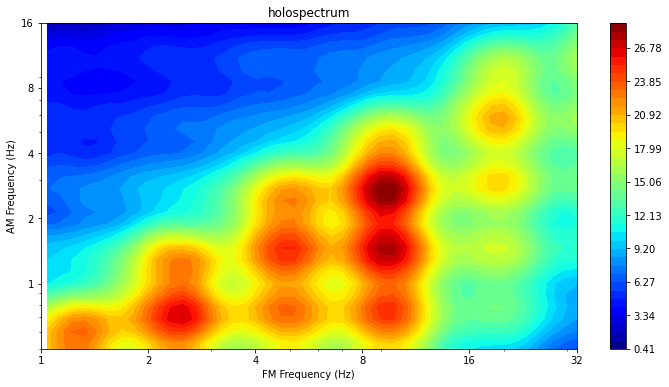

In [59]:
fig,ax=plt.subplots(1,1, figsize=(12,6))
cp = ax.contourf(fcarrier, fam, sholo.T**0.25, cmap = 'jet', shade = 'nearest', levels=np.linspace(np.min(sholo.T)**0.25, np.max(sholo.T)**0.25, 40))
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.5,16)
plt.xlim(1,32)
plt.yticks(2**np.arange(5),2**np.arange(5))
plt.xticks(2**np.arange(6),2**np.arange(6))
plt.colorbar(cp)
#cb.set_label(r'$V^{2}$', rotation=0)
ax.set_title('holospectrum')
ax.set_xlabel('FM Frequency (Hz)')
ax.set_ylabel('AM Frequency (Hz)')
plt.show()

In [ ]:
}#fcarrier
#Vector of histogram bin centers for each carrier (first-level) frequency

#fam
#Vector of histogram bin centers for each amplitude modulation (second-level) frequency

#holo
#Holospectrum of input data.

#zero padding

In [ ]:
values = []

for i in range(len(data)):
  value=np.shape(data[i])
  values.append(value)

max_value = max(values)
max_value = np.array(max_value)

new_data = [] 

In [ ]:
#zero padding pra fazer a media 

data_padded = []
width_list = []

for i in range(len(data)):
  if max(np.shape(data)) < max_value:
    width = (max_value - max(np.shape(data[i])))/2
    width_list.append(int(width))
  data_padd = np.pad(data[i], width_list[i])
  new_data.append(data_padd)


C:\Users\Camila\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
#adicionar +1 zero nos arrays que ficaram com np.shape = (2333539,)

for a in range(len(new_data)):
  if float('.'.join(str(ele) for ele in np.shape(new_data[a]))) == 2333539:
    print(a)
    new_data[a] = np.append(new_data[a],0)
  

3
5
11
18
22
26
27


In [ ]:
new_data = np.array(new_data)
new_data = np.mean(new_data, axis=0)

#testando um por um

In [ ]:
config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 50/sample_rate
config['mask_amp_mode'] = 'ratio_sig'
config['imf_opts/sd_thresh'] = 0.05

imf = emd.sift.mask_sift(new_data, **config)

In [ ]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

In [ ]:
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2


# Define sift parameters for the second level
masks = np.array([25/2**ii for ii in range(12)])/sample_rate
config = emd.sift.get_config('mask_sift')
config['mask_amp_mode'] = 'ratio_sig'
config['mask_amp'] = 2
config['max_imfs'] = 5
config['imf_opts/sd_thresh'] = 0.05
config['envelope_opts/interp_method'] = 'mono_pchip'

# Sift the first 5 first level IMFs
imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

In [ ]:
IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')

In [ ]:
carrier_hist = (1, 50, 49)

#and one for the amplitude modulations
am_hist = (1e-2, 32, 64, 'log')

#compute 1d HHT (power over carrier freq)
fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

In [ ]:
fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
shht = ndimage.gaussian_filter(hht, 2)

In [ ]:
#fcarrier
#Vector of histogram bin centers for each carrier (first-level) frequency

#fam
#Vector of histogram bin centers for each amplitude modulation (second-level) frequency

#holo
#Holospectrum of input data.

In [ ]:
fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)


In [ ]:
sholo = ndimage.gaussian_filter(holo, 1)